# Towards a first measurement of PX from the fluctuations in mocks

Let's start simple, by just measuring PX in one redshift bin, using pixels within the same HEALPix pixel

In [1]:
import numpy as np
from tqdm import tqdm
from astropy.io import fits
import os.path
import matplotlib.pyplot as plt

### Define the FFT grid associated to a given redshift bin

In [2]:
# rest-frame wavelength of Lya (Angstroms)
lam_lya=1215.67
# DESI pixel width in Angstroms
pw_A=0.8

In [3]:
# First define the official DESI wavelength grid (all wavelengths that we could possibly care about)
wave_desi_N=5000
# I know for sure that there is a pixel at 3600A, so let's make sure we cover that one
wave_desi_min=3600-500*pw_A 
wave_desi_max=wave_desi_min+wave_desi_N*pw_A
print('{:.2f} < lambda < {:.2f} [A]'.format(wave_desi_min, wave_desi_max))
print('{:.3f} < z < {:.3f}'.format(wave_desi_min/lam_lya-1, wave_desi_max/lam_lya-1))
wave_desi=np.linspace(wave_desi_min,wave_desi_max,wave_desi_N+1)

3200.00 < lambda < 7200.00 [A]
1.632 < z < 4.923


Now, for every redshift bin, let's figure out which of the pixels above are covered by its FFT grid, and which weights do they receive

In [4]:
z_alpha=2.2
dz=0.4
# figure out the center of the bin and its edges, in observed wavelength
lam_cen=lam_lya*(1+z_alpha)
lam_min=lam_lya*(1+z_alpha-0.5*dz)
lam_max=lam_lya*(1+z_alpha+0.5*dz)
print(lam_min,lam_cen,lam_max)
# the FFT grid will have a fixed length of pixels (1024)
N_fft=1024
k=np.fft.fftfreq(N_fft)*2*np.pi/pw_A
# figure out the index of the global (desi) grid that is closer to the center of the redshift bin
i_cen=round((lam_cen-wave_desi_min)/pw_A)
wave_fft_grid=wave_desi[i_cen-N_fft//2:i_cen+N_fft//2]
print(wave_fft_grid[0],'< lambda <',wave_fft_grid[-1])

3647.01 3890.1440000000002 4133.278
3480.8 < lambda < 4299.2


In [5]:
mask_fft_grid=np.ones(N_fft)
# while we use i to refer to indices in the global (desi) grid, we use j to refer to the FFT grid of this redshift
j_cen=round((lam_cen-wave_fft_grid[0])/pw_A)
# this should alway be N_fft/2
print(j_cen, N_fft//2)
# figure out the indices (in the FFT grid) that fall within the redshift bin (top hat binning)
j_min=round((lam_min-wave_fft_grid[0])/pw_A)
j_max=round((lam_max-wave_fft_grid[0])/pw_A)
print(j_min,j_max)
mask_fft_grid[:j_min]=0
mask_fft_grid[j_max:]=0

512 512
208 816


In [6]:
def angular_separation(ra1, dec1, ra2, dec2):
    # Calculate the difference in right ascension
    delta_ra = ra2 - ra1
    
    # Apply the formula for angular separation
    angular_distance = np.arccos(np.sin(dec1) * np.sin(dec2) +
                                 np.cos(dec1) * np.cos(dec2) * np.cos(delta_ra))
    
    return angular_distance

In [7]:
# path with all the delta files
deltas_path='/global/cfs/cdirs/desi/science/lya/mock_analysis/develop/ifae-ql/qq_desi_y3/v1.0.5/analysis-0/jura-124/raw_bao_unblinding/deltas_lya/Delta/'
# minimum sum of weights
min_sumw=1000 
# minimum and maximum separation, in degrees
ang_min_deg=0.1
ang_max_deg=0.15
# in radians below
ang_min=ang_min_deg*np.pi/180
ang_max=ang_max_deg*np.pi/180

### For each HEALPix pixel, measure both P1D and PX

In [8]:
def px_from_healpix(pix, verbose=False):
    fname=deltas_path+'delta-{}.fits.gz'.format(pix)
    if not os.path.isfile(fname):
        #print('skip pixel',pix)
        return None, None, None, None
    if verbose:
        print('read pixel',pix,'from file',fname)
    file = fits.open(fname)

    skewers=[]
    for hdu in file[1:]:
        if len(skewers)%100==0 and verbose:
            print(len(skewers),'read')
        # quasar meta data
        z_qso=hdu.header['Z']
        # angles in radians
        RA=hdu.header['RA']
        Dec=hdu.header['DEC']
        skewer={'z_qso':z_qso, 'RA':RA, 'Dec':Dec}
        # forest data
        wave_data=10.0**(hdu.data['LOGLAM'])
        delta_data=hdu.data['DELTA']
        weight_data=hdu.data['WEIGHT']
        # correct the weights so that they are constant in redshift (for the raw analysis only)
        weight_data *= (wave_data/4500)**3.8
        skewer['wave_data']=wave_data
        skewer['delta_data']=delta_data
        skewer['weight_data']=weight_data

        # Map the observed spectrum to the FFT grid for this particular redshift bin    
        j_min_data=round((wave_data[0]-wave_fft_grid[0])/pw_A)
        j_max_data=round((wave_data[-1]-wave_fft_grid[0])/pw_A)
        
        # map the data deltas and weights into the FFT grid
        delta_fft_grid=np.zeros(N_fft)
        weight_fft_grid=np.zeros(N_fft)
        
        # figure out whether the spectrum is cut at low-z or at high-z
        loz_cut=False
        hiz_cut=False
        if j_min_data < 0:
            loz_cut=True
            if j_max_data >=0:
                delta_fft_grid[:j_max_data]=delta_data[-j_min_data+1:]
                weight_fft_grid[:j_max_data]=weight_data[-j_min_data+1:]
        if j_max_data >= N_fft:
            hiz_cut=True
            if j_min_data < N_fft:
                delta_fft_grid[j_min_data:]=delta_data[:N_fft-j_max_data-1]
                weight_fft_grid[j_min_data:]=weight_data[:N_fft-j_max_data-1]
        if loz_cut==False and hiz_cut==False:
            delta_fft_grid[j_min_data:j_max_data+1]=delta_data
            weight_fft_grid[j_min_data:j_max_data+1]=weight_data
    
        # limit the data to the pixels within this redshift bin
        weight_fft_grid *= mask_fft_grid
        
        # store relevant information
        skewer['j_min_data']=j_min_data
        skewer['j_max_data']=j_max_data
        skewer['delta_fft_grid']=delta_fft_grid
        skewer['weight_fft_grid']=weight_fft_grid
        skewers.append(skewer)
    
    # measure unnormalized P1D and FFT of mask, squared 
    # F_m = < |f_m|^2 >
    F_m=np.zeros(N_fft)
    # mean of |w_m|^2 (FFT of mask, squared)
    w2_m=np.zeros(N_fft)
    # loop over skewers
    for skewer in skewers:
        weights=skewer['weight_fft_grid']
        deltas=skewer['delta_fft_grid']
    
        # FFT of mask
        w_m = np.fft.fft(weights)
        w2_m += abs(w_m)**2
        # FFT the product of deltas and weights
        f_m=np.fft.fft(deltas*weights)
        # dimensionless P1D
        F_m += abs(f_m)**2

    
    # measure unnormalized PX 
    # F_m = (f_m g_m^*).real
    F_G_m=np.zeros(N_fft)
    # mean of w_m v_m^* (product of FFT of masks)
    # w_v_m = (w_m v_m^*).real (product of FFT mask, real part only)
    w_v_m=np.zeros(N_fft)
    
    # number of pairs (for debugging)
    Np=0
        
    for i1 in range(1,len(skewers)):
        sk1=skewers[i1]
        w1=sk1['weight_fft_grid']
        d1=sk1['delta_fft_grid']
        # get rid of skewers with little coverage
        if np.sum(w1)<min_sumw:
            continue
        for i2 in range(i1):
            sk2=skewers[i2]
            
            # compute angular separation, in radians
            ang=angular_separation(sk1['RA'],sk1['Dec'],sk2['RA'],sk2['Dec'])
            if ang<ang_min or ang>ang_max:
                continue
    
            # correlate Fourier modes
            w2=sk2['weight_fft_grid']
            d2=sk2['delta_fft_grid']
            if np.sum(w2)<min_sumw:
                continue
                
            Np+=1
            
            # FFT of masks
            w_1_m = np.fft.fft(w1)
            w_2_m = np.fft.fft(w2)
            w_v_m += (w_1_m*np.conjugate(w_2_m)).real
     
            # and FFT again to obtain masked modes
            f_1_m=np.fft.fft(d1*w1)
            f_2_m=np.fft.fft(d2*w2)
            F_G_m += (f_1_m*np.conjugate(f_2_m)).real
    
    if verbose:
        print('Np =',Np)
        
    return F_m, w2_m, F_G_m, w_v_m

In [9]:
F_m=np.zeros(N_fft)
w2_m=np.zeros(N_fft)
F_G_m=np.zeros(N_fft)
w_v_m=np.zeros(N_fft)
# loop over 50 healpix pixels (for now)
for pix in range(50):
    if pix%10==0:
        print(pix)
    results =px_from_healpix(pix,verbose=False)
    if results[0] is not None:
        F_m += results[0]
        w2_m += results[1]
        F_G_m += results[2]
        w_v_m += results[3]

0
10
20
30
40


### Rebin the measurements and figure out the normalization of both P1D and PX

In [10]:
# define full length of FFT grid (in Angstroms)
L_fft=N_fft*pw_A
# we will rebin the wavenumbers to make them more independent, and better measured
k0_fft=2*np.pi/L_fft
dk_bin=k0_fft*4
print('dk =',dk_bin)
# stop roughly at 1/4 of the Nyquist frequency for now (equivalent to rebinning 4 pixels)
k_Ny_fft=np.pi/pw_A
k_max=k_Ny_fft/4
print('k < ',k_max)
k_edges=np.arange(0.01*dk_bin,k_max+dk_bin,dk_bin)
Nk=k_edges.size-1
print('Nk =',Nk)

dk = 0.030679615757712823
k <  0.9817477042468103
Nk = 32


In [11]:
# define the rebinning vector B_alpha_m in the notes (including negative frequencies!)
B_m=np.zeros([Nk,N_fft])
for i in range(Nk):
    #print(i,k_edges[i],k_edges[i+1])
    inbin=(abs(k)>k_edges[i]) & (abs(k)<k_edges[i+1])
    B_m[i,inbin]=1    

In [12]:
# mean wavenumber in each bin (without weights)
k_A=np.zeros(Nk)
for i in range(Nk):
    k_A[i]=np.sum(B_m[i]*abs(k))/np.sum(B_m[i])

Text(0, 0.5, 'B_m')

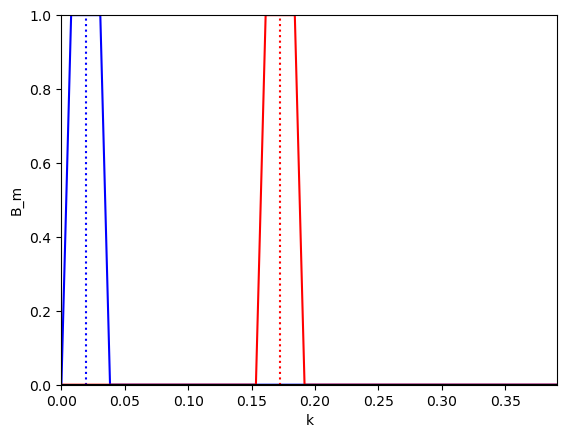

In [13]:
plt.plot(k[:N_fft//2],B_m[0][:N_fft//2],color='blue')
plt.axvline(x=k_A[0],color='blue',ls=':')
plt.plot(k[:N_fft//2],B_m[5][:N_fft//2],color='red')
plt.axvline(x=k_A[5],color='red',ls=':')
plt.axhline(y=0,color='black')

#plt.legend()
plt.xlim([0,1.2*k_A[10]])
plt.ylim([0,1])
plt.xlabel('k')
plt.ylabel('B_m')

In [14]:
# iFFT B_m to get B_a (for the convolution theorem)
B_a=np.empty([Nk,N_fft])
for i in range(Nk):
    B_a[i]=np.fft.ifft(B_m[i]).real

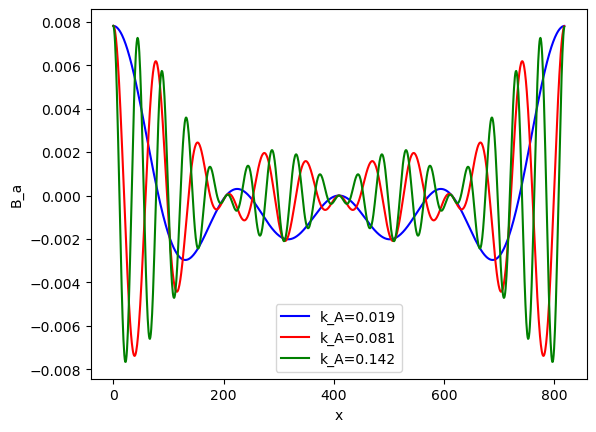

In [15]:
x = pw_A*np.arange(N_fft)
plt.plot(x,B_a[0],color='blue',label='k_A={:.3f}'.format(k_A[0]))
plt.plot(x,B_a[2],color='red',label='k_A={:.3f}'.format(k_A[2]))
plt.plot(x,B_a[4],color='green',label='k_A={:.3f}'.format(k_A[4]))
plt.xlabel('x')
plt.ylabel('B_a')
plt.legend()

Text(0, 0.5, 'p1d_BQ_m')

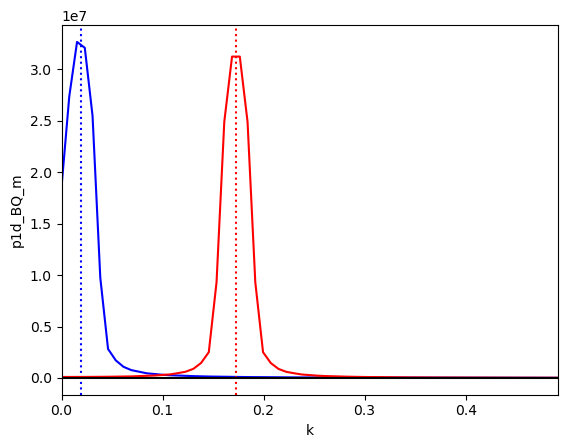

In [16]:
p1d_Q_a = np.fft.ifft(w2_m)
p1d_BQ_m=np.empty([Nk,N_fft])
for i in range(Nk):
    p1d_BQ_m[i]=np.fft.fft(B_a[i]*p1d_Q_a).real

plt.plot(k[:N_fft//2],p1d_BQ_m[0][:N_fft//2],color='blue')
plt.axvline(x=k_A[0],color='blue',ls=':')
plt.plot(k[:N_fft//2],p1d_BQ_m[5][:N_fft//2],color='red')
plt.axvline(x=k_A[5],color='red',ls=':')
plt.axhline(y=0,color='black')

plt.xlim([0,k_max/2])
plt.xlabel('k')
plt.ylabel('p1d_BQ_m')

Text(0, 0.5, 'P1D(k)')

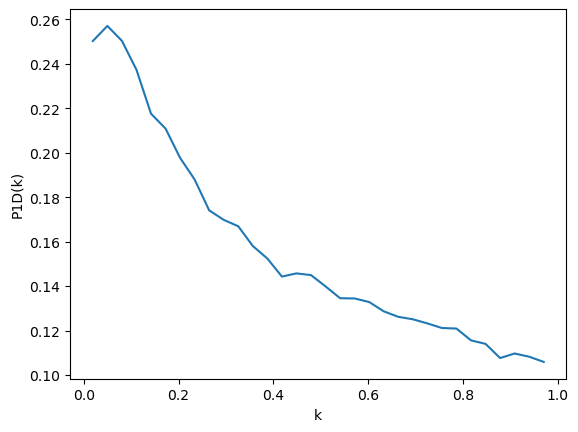

In [17]:
# normalisation 
p1d_A_A=np.empty(Nk)
for i in range(Nk):
    p1d_A_A[i]=np.sum(p1d_BQ_m[i])/pw_A
# actual summary statistics
p1d_Theta_A=np.zeros_like(p1d_A_A)
for i in range(Nk):
    p1d_Theta_A[i]=np.sum(B_m[i]*F_m)/p1d_A_A[i]
plt.plot(k_A,p1d_Theta_A,label='masked measurement')
#plt.plot(k_A,true_p1d_A,label='true P1D')
#plt.plot(k_A,model_A,label='masked model')
plt.xlabel('k')
plt.ylabel('P1D(k)')

Same, for PX

Text(0, 0.5, 'px_BQ_m')

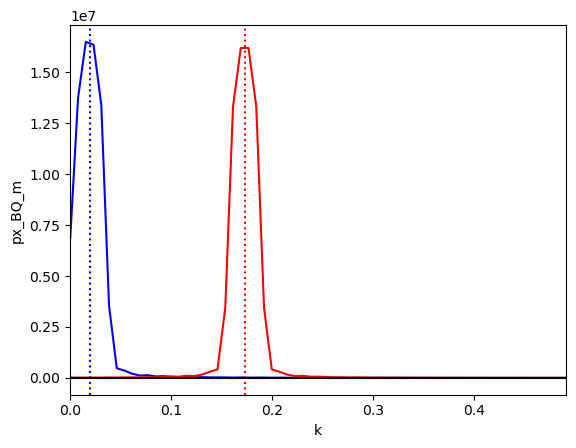

In [18]:
px_Q_a = np.fft.ifft(w_v_m)
px_BQ_m=np.empty([Nk,N_fft])
for i in range(Nk):
    px_BQ_m[i]=np.fft.fft(B_a[i]*px_Q_a).real

plt.plot(k[:N_fft//2],px_BQ_m[0][:N_fft//2],color='blue')
plt.axvline(x=k_A[0],color='blue',ls=':')
plt.plot(k[:N_fft//2],px_BQ_m[5][:N_fft//2],color='red')
plt.axvline(x=k_A[5],color='red',ls=':')
plt.axhline(y=0,color='black')

plt.xlim([0,k_max/2])
plt.xlabel('k')
plt.ylabel('px_BQ_m')

Text(0, 0.5, 'PX(k)')

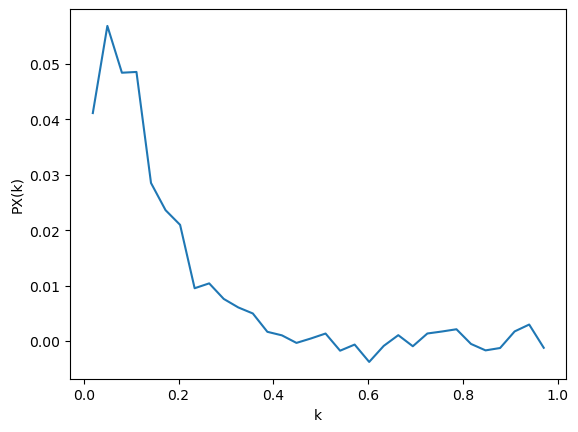

In [19]:
# normalisation (for this example, this is a constant)
px_A_A=np.empty(Nk)
for i in range(Nk):
    px_A_A[i]=np.sum(px_BQ_m[i])/pw_A
# actual summary statistics
px_Theta_A=np.zeros_like(px_A_A)
for i in range(Nk):
    px_Theta_A[i]=np.sum(B_m[i]*F_G_m)/px_A_A[i]
plt.plot(k_A,px_Theta_A,label='masked measurement')
#plt.plot(k_A,true_p1d_A,label='true P1D')
#plt.plot(k_A,model_A,label='masked model')
plt.xlabel('k')
plt.ylabel('PX(k)')